In [1]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import folium
import matplotlib as mpl
from numpy import nan
import matplotlib.pyplot as plt  
import warnings
warnings.filterwarnings("ignore")
from scipy.interpolate import make_interp_spline
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import decomposition as dcp
import statsmodels.api as sm

In [2]:
df_raw = pd.read_csv("BasicCompanyDataAsOneFile-2021-11-01.csv", low_memory=False) #,nrows=29000
pd.set_option('display.max_columns', None)
df = df_raw.sample(frac=.05,random_state=1)
df.to_csv('sample.csv', index=False)

df = pd.read_csv("sample.csv")
df

### sample DF

In [3]:
df = df[[
         'SICCode.SicText_1',
         'CompanyName',
         'SICCode.SicText_2',
         'SICCode.SicText_3',
         'SICCode.SicText_4',
         'Mortgages.NumMortOutstanding',
         'CompanyCategory',
         'CompanyStatus',
         'IncorporationDate'
        ]]

In [4]:
#preprocessing the date
df['IncorporationDate'] = pd.to_datetime(df['IncorporationDate'], errors = 'coerce')
df.dropna(subset = ['IncorporationDate'], inplace=True)
df_sic = pd.DataFrame()
df[['IncorporationDate']] = df[['IncorporationDate']].apply(lambda x: pd.to_datetime(x,format='%d/%m/%Y'))
# df_sic[['SICCode.SicText_1','IncorporationDate']] = df[['SICCode.SicText_1','IncorporationDate']]

# # set time limit
# df = df[df['IncorporationDate'] > '2020-01-01T00:00:00.000000000']
# df = df[df['IncorporationDate'] < '2020-11-01T00:00:00.000000000']

#get only year and month
df['date'] = df['IncorporationDate'].dt.strftime( '%Y-%m') #-%d
# df

In [5]:
df["SICCounts"] = df[["SICCode.SicText_1", "SICCode.SicText_2",
                         "SICCode.SicText_3", "SICCode.SicText_4"]].notnull().sum(axis=1)

In [6]:
df["SICCode.SicText_1"] = df["SICCode.SicText_1"].str[0:2]
df['SICCode.SicText_1'] = df[df["SICCode.SicText_1"]!= 'No']
df['SICCode.SicText_1'].unique()
df['SICCode.SicText_1'] = pd.to_numeric(df['SICCode.SicText_1'])
# df

In [7]:
df = df[[
         'CompanyName',
         'SICCode.SicText_1',
         'Mortgages.NumMortOutstanding',
         'CompanyCategory',
         'CompanyStatus',
         'IncorporationDate',
         'date',
         'SICCounts'
        ]]
# df.dropna(inplace=True)
# df

In [8]:
df = df.sort_values(by=['IncorporationDate'])

In [9]:
df

,CompanyName,SICCode.SicText_1,Mortgages.NumMortOutstanding,CompanyCategory,CompanyStatus,IncorporationDate,date,SICCounts
27184,HILLIER'S BACON CURING COMPANY LIMITED,NaN,2,Private Limited Company,Liquidation,1865-11-03,1865-11,1
211116,CRIEFF HYDRO LIMITED,55.0,2,Private Limited Company,Active,1867-04-23,1867-04,1
8752,BRITISH STEEL SERVICE CENTRES LIMITED,24.0,0,Private Limited Company,Liquidation,1872-07-18,1872-07,1
83154,BARNAGORE JUTE FACTORY PLC(THE),32.0,3,Public Limited Company,Active,1872-07-22,1872-07,1
70576,BOWDON BOWLING AND LAWN TENNIS CLUB (1873) LTD,93.0,0,Private Limited Company,Active,1873-04-28,1873-04,1
...,...,...,...,...,...,...,...,...
23891,MEIXIN GLOBAL LIMITED,64.0,0,Private Limited Company,Active,2021-12-10,2021-12,1
169822,BAINS GDD LIMITED,56.0,0,Private Limited Company,Active,2021-12-10,2021-12,1
42651,ATHENIUM CONSULTANCY LTD,70.0,0,Private Limited Company,Active,2021-12-10,2021-12,2
228869,ZERO FOUR FIVE ONE LTD,62.0,0,Private Limited Company,Active,2021-12-10,2021-12,1


### df categories and status

In [10]:
#Create a DataFrame1
df_categories = {
    'CompanyCategory':['Private Limited Company',
       "PRI/LBG/NSC (Private, Limited by guarantee, no share capital, use of 'Limited' exemption)",
       'PRI/LTD BY GUAR/NSC (Private, limited by guarantee, no share capital)',
       'Community Interest Company', 'Private Unlimited Company',
       'Public Limited Company',
       'United Kingdom Economic Interest Grouping', 'Private Unlimited',
       'Other company type'
    ],
   'cate_num':[1,2,3,4,5,6,7,8,9]}
df_categories = pd.DataFrame(df_categories,columns=['CompanyCategory','cate_num'])
# df_categories

#Create a DataFrame2
df_status = {
       'CompanyStatus':['Active', 'Active - Proposal to Strike off', 'Liquidation',
       'In Administration', 'Voluntary Arrangement',
       'Live but Receiver Manager on at least one charge',
       'In Administration/Administrative Receiver',
       'ADMINISTRATION ORDER', 'ADMINISTRATIVE RECEIVER', 'RECEIVERSHIP',
       'In Administration/Receiver Manager'],
   'status_num':[1,2,3,4,5,6,7,8,9,10,11]}
df_status = pd.DataFrame(df_status,columns=['CompanyStatus','status_num'])

# df["Active"]=df["CompanyStatus"].apply(lambda x:1 if x=='Active' else 0)

# df_status

In [11]:
df = df.merge(df_categories, how='left')
df = df.merge(df_status, how='left')
# df

In [12]:
df.drop(columns={'CompanyCategory'}, inplace=True)
df.drop(columns={'CompanyStatus'}, inplace=True)
df['SICCode.SicText_1'] = pd.to_numeric(df['SICCode.SicText_1'])

### business class

In [13]:
df_business_class = pd.read_csv("business_classification.csv")
df_business_class.rename(columns={"SIC": "SICCode.SicText_1"},inplace=True)
# df_business_class

In [14]:
df = df.merge(df_business_class, how='left')
# df

In [15]:
df.drop(columns={'CompanyName'}, inplace=True)
df.drop(columns={'class'}, inplace=True)

In [16]:
df = df.sort_values(by=['date'])

In [17]:
df = df[df['cate_num']<7]

In [18]:
df['SICCode.SicText_1'].nunique()

90

In [19]:
df

,SICCode.SicText_1,Mortgages.NumMortOutstanding,IncorporationDate,date,SICCounts,cate_num,status_num,num,Tertiary industry
0,NaN,2,1865-11-03,1865-11,1,1.0,3,NaN,NaN
1,55.0,2,1867-04-23,1867-04,1,1.0,1,8.0,3.0
2,24.0,0,1872-07-18,1872-07,1,1.0,3,3.0,2.0
3,32.0,3,1872-07-22,1872-07,1,6.0,1,3.0,2.0
4,93.0,0,1873-04-28,1873-04,1,1.0,1,17.0,3.0
...,...,...,...,...,...,...,...,...,...
249178,81.0,0,2021-12-03,2021-12,2,1.0,1,13.0,3.0
249177,47.0,0,2021-12-03,2021-12,1,1.0,1,6.0,3.0
249176,80.0,0,2021-12-03,2021-12,1,1.0,1,13.0,3.0
249182,47.0,0,2021-12-03,2021-12,1,1.0,1,6.0,3.0


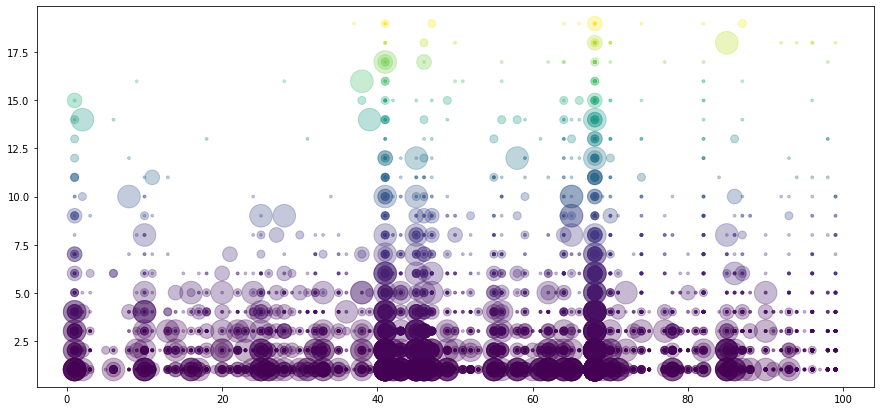

In [20]:
df_final_bottom2 = df[df['Mortgages.NumMortOutstanding']>0]
df_final2 = df_final_bottom2[df_final_bottom2['Mortgages.NumMortOutstanding']<20]
# df_final2 = df_final2[df_final2['Tertiary industry']==3]
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
plt.scatter(x=df_final2['SICCode.SicText_1'],y=df_final2['Mortgages.NumMortOutstanding'], alpha=0.3,
            s=((df_final2['SICCounts'])*2)**3,c=df_final2['Mortgages.NumMortOutstanding']**2)

In [21]:
df_final2

,SICCode.SicText_1,Mortgages.NumMortOutstanding,IncorporationDate,date,SICCounts,cate_num,status_num,num,Tertiary industry
0,NaN,2,1865-11-03,1865-11,1,1.0,3,NaN,NaN
1,55.0,2,1867-04-23,1867-04,1,1.0,1,8.0,3.0
3,32.0,3,1872-07-22,1872-07,1,6.0,1,3.0,2.0
9,85.0,2,1878-04-16,1878-04,4,1.0,1,15.0,3.0
10,18.0,1,1878-10-29,1878-10,1,1.0,1,3.0,2.0
...,...,...,...,...,...,...,...,...,...
249128,56.0,1,2021-12-03,2021-12,1,1.0,1,8.0,3.0
249156,68.0,1,2021-12-03,2021-12,1,1.0,1,11.0,3.0
249202,68.0,2,2021-12-03,2021-12,1,1.0,1,11.0,3.0
249185,41.0,2,2021-12-03,2021-12,1,1.0,1,5.0,2.0


Logistic regression base on company categories

In [22]:
import numpy as np
import statsmodels.api as sm
from scipy import stats
from matplotlib import pyplot as plt

plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

In [23]:
Y = df_final2[['SICCounts']]
X = df_final2[['Mortgages.NumMortOutstanding']]

In [25]:
# Poisson regression
import statsmodels.api as sm
exog, endog = sm.add_constant(X), Y
mod = sm.GLM(endog, exog,
             family=sm.families.Poisson(link=sm.families.links.log))
res = mod.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              SICCounts   No. Observations:                27504
Model:                            GLM   Df Residuals:                    27502
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -31857.
Date:                Thu, 16 Dec 2021   Deviance:                       5547.3
Time:                        15:53:53   Pearson chi2:                 7.49e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

#### Data pre-processing

In [26]:
SIC_1 = df_final2[df_final2['cate_num']==1.0].groupby('num').mean()
SIC_2 = df_final2[df_final2['cate_num']==2.0].groupby('num').mean()
SIC_3 = df_final2[df_final2['cate_num']==3.0].groupby('num').mean()
SIC_4 = df_final2[df_final2['cate_num']==4.0].groupby('num').mean()
SIC_5 = df_final2[df_final2['cate_num']==5.0].groupby('num').mean()
SIC_6 = df_final2[df_final2['cate_num']==6.0].groupby('num').mean()

ave_outstand_1 = SIC_1[['Mortgages.NumMortOutstanding']].T
ave_outstand_2 = SIC_2[['Mortgages.NumMortOutstanding']].T
ave_outstand_3 = SIC_3[['Mortgages.NumMortOutstanding']].T
ave_outstand_4 = SIC_4[['Mortgages.NumMortOutstanding']].T
ave_outstand_5 = SIC_5[['Mortgages.NumMortOutstanding']].T
ave_outstand_6 = SIC_6[['Mortgages.NumMortOutstanding']].T

all_ave_outstand = pd.concat([
    ave_outstand_1,
    ave_outstand_2,
    ave_outstand_3,
    ave_outstand_4,
    ave_outstand_5,
    ave_outstand_6,
])

all_ave_outstand.reset_index(inplace=True)
all_ave_outstand.drop(columns={"index"},inplace=True)
all_ave_outstand

num,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0
0,2.425486,3.09434,2.000000,2.278523,2.396324,1.981224,2.013356,2.069331,1.813679,2.056962,2.913762,1.879696,1.890497,1.533333,1.662338,1.926506,1.842857,1.772798,2.155172,2.063953
1,1.000000,NaN,NaN,3.000000,1.000000,1.333333,1.000000,3.100000,1.000000,2.500000,1.000000,2.555556,1.714286,1.000000,2.025000,2.075472,2.045455,1.820513,NaN,NaN
2,3.000000,3.00000,2.500000,2.000000,1.000000,1.000000,2.333333,2.166667,1.600000,1.000000,2.235294,2.272727,1.437500,11.000000,2.441176,2.482759,2.636364,2.925926,1.400000,2.000000
3,1.000000,NaN,1.000000,3.000000,NaN,NaN,NaN,2.500000,NaN,NaN,2.333333,2.000000,5.000000,NaN,1.000000,1.444444,1.400000,NaN,NaN,NaN
4,2.000000,1.00000,2.666667,NaN,2.000000,2.000000,NaN,2.000000,NaN,2.800000,2.555556,1.888889,1.800000,NaN,1.000000,1.000000,1.000000,11.000000,NaN,1.000000
5,NaN,2.00000,2.428571,4.000000,2.800000,3.333333,3.333333,1.500000,3.500000,3.092593,5.250000,3.888889,2.250000,NaN,NaN,9.000000,1.500000,5.000000,NaN,3.000000


In [27]:
ave_count_1 = SIC_1[['SICCounts']].T
ave_count_2 = SIC_2[['SICCounts']].T
ave_count_3 = SIC_3[['SICCounts']].T
ave_count_4 = SIC_4[['SICCounts']].T
ave_count_5 = SIC_5[['SICCounts']].T
ave_count_6 = SIC_6[['SICCounts']].T

all_ave_count = pd.concat([
    ave_count_1,
    ave_count_2,
    ave_count_3,
    ave_count_4,
    ave_count_5,
    ave_count_6
])


all_ave_count = all_ave_count.T
all_ave_count

,SICCounts,SICCounts,SICCounts,SICCounts,SICCounts,SICCounts
num,,,,,,
1.0,1.410367,2.000000,2.500000,1.666667,1.307692,NaN
2.0,1.490566,NaN,2.000000,NaN,1.000000,1.333333
3.0,1.281076,NaN,1.000000,1.000000,3.000000,1.714286
4.0,1.244966,4.000000,4.000000,1.000000,NaN,1.000000
5.0,1.288617,1.000000,1.000000,NaN,2.000000,1.400000
6.0,1.225963,2.333333,1.400000,NaN,1.666667,1.333333
7.0,1.155259,4.000000,1.666667,NaN,NaN,1.000000
8.0,1.150897,2.200000,2.000000,3.000000,2.000000,2.500000
9.0,1.300708,2.500000,1.000000,NaN,NaN,1.500000


In [28]:
all_ave_outstand = all_ave_outstand.T

In [29]:
all_ave_outstand[0]

num
1.0     2.425486
2.0     3.094340
3.0     2.000000
4.0     2.278523
5.0     2.396324
6.0     1.981224
7.0     2.013356
8.0     2.069331
9.0     1.813679
10.0    2.056962
11.0    2.913762
12.0    1.879696
13.0    1.890497
14.0    1.533333
15.0    1.662338
16.0    1.926506
17.0    1.842857
18.0    1.772798
19.0    2.155172
20.0    2.063953
Name: 0, dtype: float64

In [30]:
all_ave_count.set_axis([0,1,2,3,4,5], axis=1, inplace=True)
all_ave_count

,0,1,2,3,4,5
num,,,,,,
1.0,1.410367,2.000000,2.500000,1.666667,1.307692,NaN
2.0,1.490566,NaN,2.000000,NaN,1.000000,1.333333
3.0,1.281076,NaN,1.000000,1.000000,3.000000,1.714286
4.0,1.244966,4.000000,4.000000,1.000000,NaN,1.000000
5.0,1.288617,1.000000,1.000000,NaN,2.000000,1.400000
6.0,1.225963,2.333333,1.400000,NaN,1.666667,1.333333
7.0,1.155259,4.000000,1.666667,NaN,NaN,1.000000
8.0,1.150897,2.200000,2.000000,3.000000,2.000000,2.500000
9.0,1.300708,2.500000,1.000000,NaN,NaN,1.500000


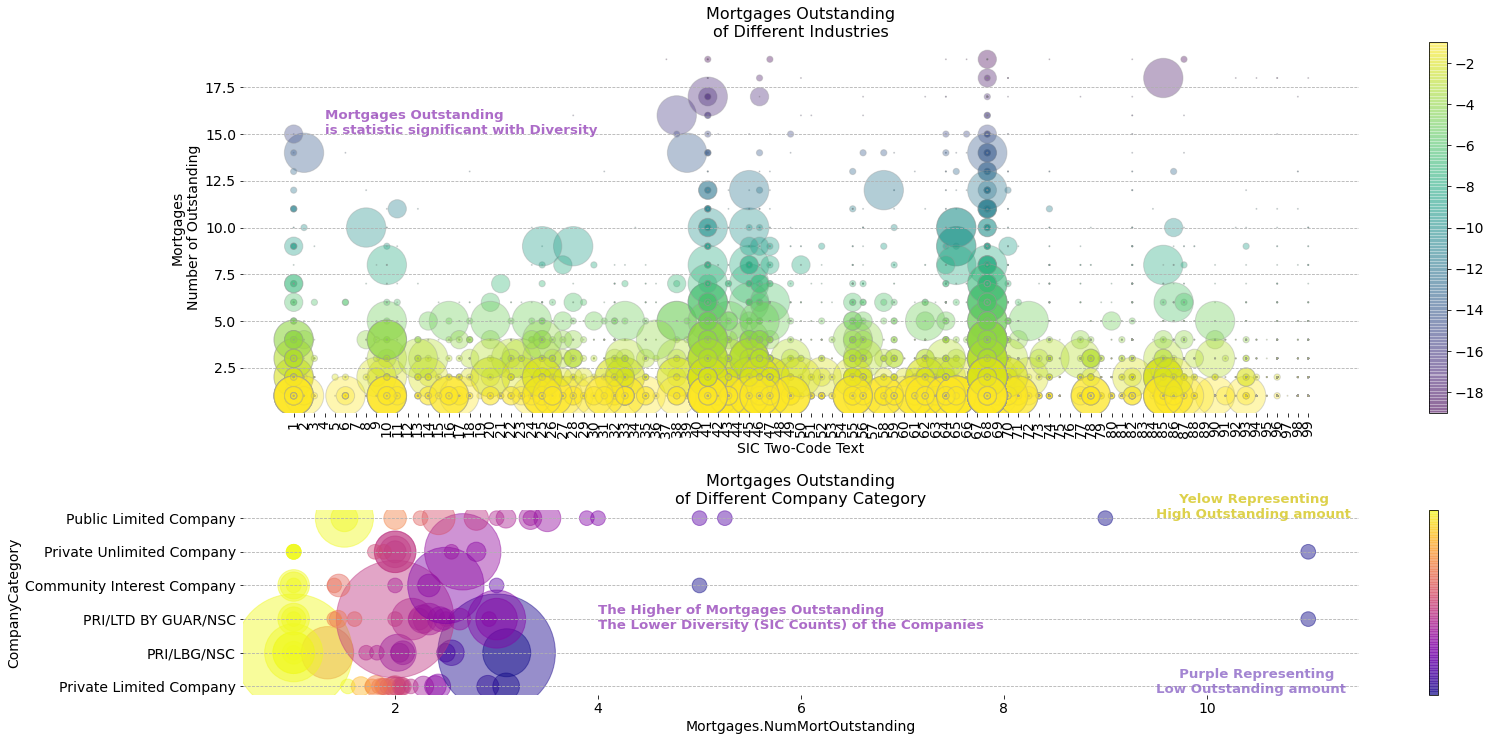

In [31]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


fig = plt.figure(figsize=(25,12))
plt.subplots_adjust(wspace=0.35, 
                    hspace=0.35)

spec = gridspec.GridSpec(ncols=1, nrows=2,
                         height_ratios=[2, 1]
#                          width_ratios=[1,1,2]
                        )

############### Frist Plot #####################
ax0 = fig.add_subplot(spec[0,0]) # upper pie

df_final_bottom2 = df[df['Mortgages.NumMortOutstanding']>0]
df_final2 = df_final_bottom2[df_final_bottom2['Mortgages.NumMortOutstanding']<20]
# df_final2 = df_final2[df_final2['Tertiary industry']==2]
fg0=ax0.scatter(
    x=df_final2['SICCode.SicText_1'],
    y=df_final2['Mortgages.NumMortOutstanding'], 
    alpha=0.36,
    s=df_final2['SICCounts']**5.3,
    c=-df_final2['Mortgages.NumMortOutstanding'],
    edgecolors= '#9a9a9a'
)

# spines
ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.grid(axis='y',ls = '--')

ax0.set_ylabel('Mortgages\nNumber of Outstanding')
ax0.set_xlabel('SIC Two-Code Text')

SIC_list = range(1, 100)
ax0.set_xticks(SIC_list)
ax0.set_title('Mortgages Outstanding\nof Different Industries',fontsize=16)
plt.xticks(rotation='vertical')

fig.colorbar(fg0,orientation='vertical')

ax0.annotate("Mortgages Outstanding\nis statistic significant with Diversity",
             xy=(4,15), xytext=(4,15), weight='bold',
            size = 13.4 , color="#892eb1", alpha=0.7)


############### Second Plot #####################
ax1 = fig.add_subplot(spec[1,0]) # lower pie

for i in range(0,6):
    fg=ax1.scatter(
        x=all_ave_outstand[i],
        y=[i+1]*20,
        alpha=0.45,
        c=1/all_ave_outstand[i],
        s=(all_ave_count[i]*6)**3,
        cmap='plasma'
    )

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.05)
cbar1 = fig.colorbar(fg,orientation='vertical', ticks=[-1, 0, 1])
cbar1.ax.set_yticklabels(['< -1', '0', '> 1'])

# spines
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.grid(axis='y',ls = '--')

ax1.set_ylabel('CompanyCategory')
ax1.set_xlabel('Mortgages.NumMortOutstanding')
ax1.set_title('Mortgages Outstanding\nof Different Company Category',fontsize=16)

ax1.annotate("The Higher of Mortgages Outstanding\nThe Lower Diversity (SIC Counts) of the Companies",
             xy=(4,2.7), xytext=(4,2.7), weight='bold',
            size = 13.4 , color="#892eb1", alpha=0.7)

ax1.annotate("     Yelow Representing\nHigh Outstanding amount",
             xy=(9.5,6), xytext=(9.5,6), weight='bold',
            size = 13.4 , color="#cfbe00", alpha=0.7)

ax1.annotate("     Purple Representing\nLow Outstanding amount",
             xy=(9.5,0.8), xytext=(9.5,0.8), weight='bold',
            size = 13.4 , color="#7d52bf", alpha=0.7)

categories_list = [
       'Private Limited Company',
       'Private Limited Company',
       'PRI/LBG/NSC',
       'PRI/LTD BY GUAR/NSC',
       'Community Interest Company',
       'Private Unlimited Company',
       'Public Limited Company'
]
ax1.set_yticklabels(categories_list)

plt.show()